# Setting up

## load modules

In [1]:
# %%capture
%load_ext autoreload
%autoreload 2
%matplotlib inline
from typing import Callable, List, Optional, Union
import os
import sys
import numpy as np
import xarray as xr
from dask.distributed import Client, LocalCluster
from tqdm import tqdm
import matplotlib.pyplot as plt 
from scipy.signal import periodogram, find_peaks, correlate, correlation_lags
import re
import warnings
from os import listdir
from pathlib import Path
import cv2
import dask as da
import math
import dask.array as darr
import xarray as xr
import zarr as zr
from natsort import natsorted
from tifffile import TiffFile, imread
import matplotlib
import shutil
from collections import defaultdict
from scipy.stats import zscore
from scipy.signal import savgol_filter
import math 
import ffmpeg
import functools as fct
import _operator





### Minian import 

In [2]:
from minian.utilities import (
    TaskAnnotation,
)

## set path and parameters

In [3]:
# Set up Initial Basic Parameters#
dpath = "/scratch/09117/xz6783/minian/Cat_Odor_Conflict/Sessions combined/2N6"
# dpath = "/scratch/09656/dhh3/gdrive_duy_miniscope_local/Satiation/Session Combined/1H6"
dpath = os.path.abspath(dpath)
framesPerFile = 1000

# Pre-processing Parameters#
# param_load_videos = {
#     "start": None,
#     "end": None,
#     "pattern": "[0-9]+\.avi$", 
#     "dtype": np.uint8,
#     "downsample": dict(frame=1, height=1, width=1),
#     "downsample_strategy": "subset",
# }

param_load_videos = {
    "pattern": "[0-9]+\.avi$",
    "dtype": np.uint8,
    "downsample": dict(frame=1, height=1, width=1),
    "downsample_strategy": "subset",
}

os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
# os.environ["NUMBA_NUM_THREADS"] = "1"

## functions for loading in all videos

In [4]:
# def load_videos(
#     vpath,
#     start=None,
#     end=None,
#     pattern=None,
#     dtype=np.float64,
#     in_memory=False,
#     downsample=None,
#     downsample_strategy="subset",
#     post_process=None,
# ):
#     if pattern is None:
#         if start is not None and end is not None:
#             pattern = r"[0-9]+\.avi$".format(start, end)
#         else:
#             pattern = r"[0-9]+\.avi$"

#     """
#     Load videos from the folder specified in `vpath` and according to the regex
#     `pattern`, then concatenate them together across time and return a
#     `xarray.DataArray` representation of the concatenated videos. The default
#     assumption is video filenames start with ``msCam`` followed by at least a
#     number, and then followed by ``.avi``. In addition, it is assumed that the
#     name of the folder correspond to a recording session identifier.

#     Parameters
#     ----------
#     vpath : str
#         The path to search for videos
#     pattern : str, optional
#         The pattern that describes filenames of videos. (Default value =
#         'msCam[0-9]+\.avi')

#     Returns
#     -------
#     xarray.DataArray or None
#         The labeled 3-d array representation of the videos with dimensions:
#         ``frame``, ``height`` and ``width``. Returns ``None`` if no data was
#         found in the specified folder.
#     """
#     vpath = os.path.normpath(vpath)
#     ssname = os.path.basename(vpath)
#     vlist = natsorted(
#         [vpath + os.sep + v for v in os.listdir(vpath) if re.search(pattern, v)]
#     )
#     # Filter vlist based on the specified range
#     if "start" in param_load_videos and param_load_videos["start"] is not None:
#         start_frame = param_load_videos["start"]
#     else:
#         start_frame = 0

#     if "end" in param_load_videos and param_load_videos["end"] is not None:
#         end_frame = param_load_videos["end"]
#     else:
#         end_frame = float('inf')  # A placeholder for infinity to include all frames till the end

#     vlist = [v for v in vlist if start_frame <= int(re.search(r'(\d+)', os.path.basename(v)).group(1)) <= end_frame]


#     if not vlist:
#         raise FileNotFoundError(
#             "No data with pattern {}"
#             " found in the specified folder {}".format(pattern, vpath)
#         )
#     print("loading {} videos in folder {}".format(len(vlist), vpath))

#     file_extension = os.path.splitext(vlist[0])[1]
#     if file_extension in (".avi", ".mkv"):
#         movie_load_func = load_avi_lazy
#     elif file_extension == ".tif":
#         movie_load_func = load_tif_lazy
#     else:
#         raise ValueError("Extension not supported.")

#     varr_list = [movie_load_func(v) for v in vlist]
#     varr = darr.concatenate(varr_list, axis=0)
#     varr = xr.DataArray(
#         varr,
#         dims=["frame", "height", "width"],
#         coords=dict(
#             frame=np.arange(varr.shape[0]),
#             height=np.arange(varr.shape[1]),
#             width=np.arange(varr.shape[2]),
#         ),
#     )
#     if dtype:
#         varr = varr.astype(dtype)
#     if downsample:
#         bin_eg = {d: np.arange(0, varr.sizes[d], w) for d, w in downsample.items()}
#         if downsample_strategy == "mean":
#             varr = (
#                 varr.coarsen(**downsample, boundary="trim")
#                 .mean()
#                 .assign_coords(**bin_eg)
#             )
#         elif downsample_strategy == "subset":
#             varr = varr.sel(**bin_eg)
#         else:
#             warnings.warn("unrecognized downsampling strategy", RuntimeWarning)
#     varr = varr.rename("fluorescence")
#     if post_process:
#         varr = post_process(varr, vpath, ssname, vlist, varr_list)
#     return varr

# def load_tif_lazy(fname):
#     data = TiffFile(fname)
#     f = len(data.pages)

#     fmread = da.delayed(load_tif_perframe)
#     flist = [fmread(fname, i) for i in range(f)]

#     sample = flist[0].compute()
#     arr = [
#         da.array.from_delayed(fm, dtype=sample.dtype, shape=sample.shape)
#         for fm in flist
#     ]
#     return da.array.stack(arr, axis=0)


# def load_tif_perframe(fname, fid):
#     return imread(fname, key=fid)


# def load_avi_lazy(fname):
#     cap = cv2.VideoCapture(fname)
#     f = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
#     fmread = da.delayed(load_avi_perframe)
#     flist = [fmread(fname, i) for i in range(f)]
#     sample = flist[0].compute()
#     arr = [
#         da.array.from_delayed(fm, dtype=sample.dtype, shape=sample.shape)
#         for fm in flist
#     ]
#     return da.array.stack(arr, axis=0)


# def load_avi_perframe(fname, fid):
#     cap = cv2.VideoCapture(fname)
#     h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
#     w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
#     cap.set(cv2.CAP_PROP_POS_FRAMES, fid)
#     ret, fm = cap.read()
#     if ret:
#         return cv2.cvtColor(fm, cv2.COLOR_RGB2GRAY)
#     else:
#         print("frame read failed for frame {}".format(fid))
#         return np.zeros((h, w))


In [5]:
def load_videos(
    vpath: str,
    pattern=r"[0-9]+\.avi$",
    dtype: Union[str, type] = np.float64,
    downsample: Optional[dict] = None,
    downsample_strategy="subset",
    post_process: Optional[Callable] = None,
) -> xr.DataArray:
    """
    Load multiple videos in a folder and return a `xr.DataArray`.

    Load videos from the folder specified in `vpath` and according to the regex
    `pattern`, then concatenate them together and return a `xr.DataArray`
    representation of the concatenated videos. The videos are sorted by
    filenames with :func:`natsort.natsorted` before concatenation. Optionally
    the data can be downsampled, and the user can pass in a custom callable to
    post-process the result.

    Parameters
    ----------
    vpath : str
        The path containing the videos to load.
    pattern : regexp, optional
        The regexp matching the filenames of the videso. By default
        `r"msCam[0-9]+\.avi$"`, which can be interpreted as filenames starting
        with "msCam" followed by at least a number, and then followed by ".avi".
    dtype : Union[str, type], optional
        Datatype of the resulting DataArray, by default `np.float64`.
    downsample : dict, optional
        A dictionary mapping dimension names to an integer downsampling factor.
        The dimension names should be one of "height", "width" or "frame". By
        default `None`.
    downsample_strategy : str, optional
        How the downsampling should be done. Only used if `downsample` is not
        `None`. Either `"subset"` where data points are taken at an interval
        specified in `downsample`, or `"mean"` where mean will be taken over
        data within each interval. By default `"subset"`.
    post_process : Callable, optional
        An user-supplied custom function to post-process the resulting array.
        Four arguments will be passed to the function: the resulting DataArray
        `varr`, the input path `vpath`, the list of matched video filenames
        `vlist`, and the list of DataArray before concatenation `varr_list`. The
        function should output another valide DataArray. In other words, the
        function should have signature `f(varr: xr.DataArray, vpath: str, vlist:
        List[str], varr_list: List[xr.DataArray]) -> xr.DataArray`. By default
        `None`

    Returns
    -------
    varr : xr.DataArray
        The resulting array representation of the input movie. Should have
        dimensions ("frame", "height", "width").

    Raises
    ------
    FileNotFoundError
        if no files under `vpath` match the pattern `pattern`
    ValueError
        if the matched files does not have extension ".avi", ".mkv" or ".tif"
    NotImplementedError
        if `downsample_strategy` is not "subset" or "mean"
    """
    vpath = os.path.normpath(vpath)
    vlist = natsorted(
        [vpath + os.sep + v for v in os.listdir(vpath) if re.search(pattern, v)]
    )
    if not vlist:
        raise FileNotFoundError(
            "No data with pattern {}"
            " found in the specified folder {}".format(pattern, vpath)
        )
    print("loading {} videos in folder {}".format(len(vlist), vpath))

    file_extension = os.path.splitext(vlist[0])[1]
    if file_extension in (".avi", ".mkv"):
        movie_load_func = load_avi_lazy
    elif file_extension == ".tif":
        movie_load_func = load_tif_lazy
    else:
        raise ValueError("Extension not supported.")

    varr_list = [movie_load_func(v) for v in vlist]
    varr = darr.concatenate(varr_list, axis=0)
    varr = xr.DataArray(
        varr,
        dims=["frame", "height", "width"],
        coords=dict(
            frame=np.arange(varr.shape[0]),
            height=np.arange(varr.shape[1]),
            width=np.arange(varr.shape[2]),
        ),
    )
    if dtype:
        varr = varr.astype(dtype)
    if downsample:
        if downsample_strategy == "mean":
            varr = varr.coarsen(**downsample, boundary="trim", coord_func="min").mean()
        elif downsample_strategy == "subset":
            varr = varr.isel(**{d: slice(None, None, w) for d, w in downsample.items()})
        else:
            raise NotImplementedError("unrecognized downsampling strategy")
    varr = varr.rename("fluorescence")
    if post_process:
        varr = post_process(varr, vpath, vlist, varr_list)
    arr_opt = fct.partial(custom_arr_optimize, keep_patterns=["^load_avi_ffmpeg"])
    with da.config.set(array_optimize=arr_opt):
        varr = da.optimize(varr)[0]
    return varr


def load_tif_lazy(fname: str) -> darr.array:
    """
    Lazy load a tif stack of images.

    Parameters
    ----------
    fname : str
        The filename of the tif stack to load.

    Returns
    -------
    arr : darr.array
        Resulting dask array representation of the tif stack.
    """
    data = TiffFile(fname)
    f = len(data.pages)

    fmread = da.delayed(load_tif_perframe)
    flist = [fmread(fname, i) for i in range(f)]

    sample = flist[0].compute()
    arr = [
        da.array.from_delayed(fm, dtype=sample.dtype, shape=sample.shape)
        for fm in flist
    ]
    return da.array.stack(arr, axis=0)


def load_tif_perframe(fname: str, fid: int) -> np.ndarray:
    """
    Load a single image from a tif stack.

    Parameters
    ----------
    fname : str
        The filename of the tif stack.
    fid : int
        The index of the image to load.

    Returns
    -------
    arr : np.ndarray
        Array representation of the image.
    """
    return imread(fname, key=fid)


def load_avi_lazy_framewise(fname: str) -> darr.array:
    cap = cv2.VideoCapture(fname)
    f = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    fmread = da.delayed(load_avi_perframe)
    flist = [fmread(fname, i) for i in range(f)]
    sample = flist[0].compute()
    arr = [
        da.array.from_delayed(fm, dtype=sample.dtype, shape=sample.shape)
        for fm in flist
    ]
    return da.array.stack(arr, axis=0)


def load_avi_lazy(fname: str) -> darr.array:
    """
    Lazy load an avi video.

    This function construct a single delayed task for loading the video as a
    whole.

    Parameters
    ----------
    fname : str
        The filename of the video to load.

    Returns
    -------
    arr : darr.array
        The array representation of the video.
    """
    probe = ffmpeg.probe(fname)
    video_info = next(s for s in probe["streams"] if s["codec_type"] == "video")
    w = int(video_info["width"])
    h = int(video_info["height"])
    f = int(video_info["nb_frames"])
    return da.array.from_delayed(
        da.delayed(load_avi_ffmpeg)(fname, h, w, f), dtype=np.uint8, shape=(f, h, w)
    )


def load_avi_ffmpeg(fname: str, h: int, w: int, f: int) -> np.ndarray:
    """
    Load an avi video using `ffmpeg`.

    This function directly invoke `ffmpeg` using the `python-ffmpeg` wrapper and
    retrieve the data from buffer.

    Parameters
    ----------
    fname : str
        The filename of the video to load.
    h : int
        The height of the video.
    w : int
        The width of the video.
    f : int
        The number of frames in the video.

    Returns
    -------
    arr : np.ndarray
        The resulting array. Has shape (`f`, `h`, `w`).
    """
    out_bytes, err = (
        ffmpeg.input(fname)
        .video.output("pipe:", format="rawvideo", pix_fmt="gray")
        .run(capture_stdout=True)
    )
    return np.frombuffer(out_bytes, np.uint8).reshape(f, h, w)


def load_avi_perframe(fname: str, fid: int) -> np.ndarray:
    cap = cv2.VideoCapture(fname)
    h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    cap.set(cv2.CAP_PROP_POS_FRAMES, fid)
    ret, fm = cap.read()
    if ret:
        return cv2.cvtColor(fm, cv2.COLOR_RGB2GRAY)
    else:
        print("frame read failed for frame {}".format(fid))
        return np.zeros((h, w))
    
ANNOTATIONS = {
    "from-zarr-store": {"resources": {"MEM": 1}},
    "load_avi_ffmpeg": {"resources": {"MEM": 1}},
    "est_motion_chunk": {"resources": {"MEM": 1}},
    "transform_perframe": {"resources": {"MEM": 0.5}},
    "pnr_perseed": {"resources": {"MEM": 0.5}},
    "ks_perseed": {"resources": {"MEM": 0.5}},
    "smooth_corr": {"resources": {"MEM": 1}},
    "vectorize_noise_fft": {"resources": {"MEM": 1}},
    "vectorize_noise_welch": {"resources": {"MEM": 1}},
    "update_spatial_block": {"resources": {"MEM": 1}},
    "tensordot_restricted": {"resources": {"MEM": 1}},
    "update_temporal_block": {"resources": {"MEM": 1}},
    "merge_restricted": {"resources": {"MEM": 1}},
}
"""
Dask annotations that should be applied to each task.

This is a `dict` mapping task names (actually patterns) to a `dict` of dask
annotations that should be applied to the tasks. It is mainly used to constrain
number of tasks that can be concurrently in memory for each worker.

See Also
-------
:doc:`distributed:resources`
"""
    
FAST_FUNCTIONS = [
    darr.core.getter_inline,
    darr.core.getter,
    _operator.getitem,
    zr.core.Array,
    darr.chunk.astype,
    darr.core.concatenate_axes,
    darr.core._vindex_slice,
    darr.core._vindex_merge,
    darr.core._vindex_transpose,
]
"""
List of fast functions that should be inlined during optimization.

See Also
-------
:doc:`dask:optimize`
"""

def custom_arr_optimize(
    dsk: dict,
    keys: list,
    fast_funcs: list = FAST_FUNCTIONS,
    inline_patterns=[],
    rename_dict: Optional[dict] = None,
    rewrite_dict: Optional[dict] = None,
    keep_patterns=[],
) -> dict:
    """
    Customized implementation of array optimization function.

    Parameters
    ----------
    dsk : dict
        Input dask task graph.
    keys : list
        Output task keys.
    fast_funcs : list, optional
        List of fast functions to be inlined. By default :const:`FAST_FUNCTIONS`.
    inline_patterns : list, optional
        List of patterns of task keys to be inlined. By default `[]`.
    rename_dict : dict, optional
        Dictionary mapping old task keys to new ones. Only used during fusing of
        tasks. By default `None`.
    rewrite_dict : dict, optional
        Dictionary mapping old task key substrings to new ones. Applied at the
        end of optimization to all task keys. By default `None`.
    keep_patterns : list, optional
        List of patterns of task keys that should be preserved during
        optimization. By default `[]`.

    Returns
    -------
    dsk : dict
        Optimized dask graph.

    See Also
    -------
    :doc:`dask:optimize`
    `dask.array.optimization.optimize`
    """
    # inlining lots of array operations ref:
    # https://github.com/dask/dask/issues/6668
    if rename_dict:
        key_renamer = fct.partial(custom_fused_keys_renamer, rename_dict=rename_dict)
    else:
        key_renamer = custom_fused_keys_renamer
    keep_keys = []
    if keep_patterns:
        key_ls = list(dsk.keys())
        for pat in keep_patterns:
            keep_keys.extend(list(filter(lambda k: check_key(k, pat), key_ls)))
    dsk = darr.optimization.optimize(
        dsk,
        keys,
        fuse_keys=keep_keys,
        fast_functions=fast_funcs,
        rename_fused_keys=key_renamer,
    )
    if inline_patterns:
        dsk = inline_pattern(dsk, inline_patterns, inline_constants=False)
    if rewrite_dict:
        dsk_old = dsk.copy()
        for key, val in dsk_old.items():
            key_new = rewrite_key(key, rewrite_dict)
            if key_new != key:
                dsk[key_new] = val
                dsk[key] = key_new
    return dsk

def custom_fused_keys_renamer(
    keys: list, max_fused_key_length=120, rename_dict: Optional[dict] = None
) -> str:
    """
    Custom implmentation to create new keys for `fuse` tasks.

    Uses custom `split_key` implementation.

    Parameters
    ----------
    keys : list
        List of task keys that should be fused together.
    max_fused_key_length : int, optional
        Used to limit the maximum string length for each renamed key. If `None`,
        there is no limit. By default `120`.
    rename_dict : dict, optional
        Dictionary used to rename keys during fuse. By default `None`.

    Returns
    -------
    fused_key : str
        The fused task key.

    See Also
    -------
    split_key
    dask.optimization.fuse
    """
    it = reversed(keys)
    first_key = next(it)
    typ = type(first_key)

    if max_fused_key_length:  # Take into account size of hash suffix
        max_fused_key_length -= 5

    def _enforce_max_key_limit(key_name):
        if max_fused_key_length and len(key_name) > max_fused_key_length:
            name_hash = f"{hash(key_name):x}"[:4]
            key_name = f"{key_name[:max_fused_key_length]}-{name_hash}"
        return key_name

    if typ is str:
        first_name = split_key(first_key, rename_dict=rename_dict)
        names = {split_key(k, rename_dict=rename_dict) for k in it}
        names.discard(first_name)
        names = sorted(names)
        names.append(first_key)
        concatenated_name = "-".join(names)
        return _enforce_max_key_limit(concatenated_name)
    elif typ is tuple and len(first_key) > 0 and isinstance(first_key[0], str):
        first_name = split_key(first_key, rename_dict=rename_dict)
        names = {split_key(k, rename_dict=rename_dict) for k in it}
        names.discard(first_name)
        names = sorted(names)
        names.append(first_key[0])
        concatenated_name = "-".join(names)
        return (_enforce_max_key_limit(concatenated_name),) + first_key[1:]
    
def check_key(key: Union[str, tuple], pat: str) -> bool:
    """
    Check whether `key` contains pattern.

    Parameters
    ----------
    key : Union[str, tuple]
        Input key. If a `tuple` then the first element will be used to check.
    pat : str
        Pattern to check.

    Returns
    -------
    bool
        Whether `key` contains pattern.
    """
    try:
        return bool(re.search(pat, key))
    except TypeError:
        return bool(re.search(pat, key[0]))
    
def split_key(key: Union[tuple, str], rename_dict: Optional[dict] = None) -> str:
    """
    Split, rename and filter task keys.

    This is custom implementation that only keeps keys found in :const:`ANNOTATIONS`.

    Parameters
    ----------
    key : Union[tuple, str]
        The input task key.
    rename_dict : dict, optional
        Dictionary used to rename keys. By default `None`.

    Returns
    -------
    new_key : str
        New key.
    """
    if type(key) is tuple:
        key = key[0]
    kls = key.split("-")
    if rename_dict:
        kls = list(map(lambda k: rename_dict.get(k, k), kls))
    kls_ft = list(filter(lambda k: k in ANNOTATIONS.keys(), kls))
    if kls_ft:
        return "-".join(kls_ft)
    else:
        return kls[0]

## start cluster

In [6]:

cluster = LocalCluster(
    n_workers=30,
    memory_limit="5GB",
    resources={"MEM": 1},
    threads_per_worker=2,
    dashboard_address=":8787",
)
annt_plugin = TaskAnnotation()
cluster.scheduler.add_plugin(annt_plugin)
client = Client(cluster)

# Misalignment detection

## loading videos and visualization

In [7]:
param_load_videos

{'pattern': '[0-9]+\\.avi$',
 'dtype': numpy.uint8,
 'downsample': {'frame': 1, 'height': 1, 'width': 1},
 'downsample_strategy': 'subset'}

In [8]:
%%time
varr = load_videos(dpath, **param_load_videos)

loading 56 videos in folder /scratch/09117/xz6783/minian/Cat_Odor_Conflict/Sessions combined/2N6
CPU times: user 167 ms, sys: 355 ms, total: 522 ms
Wall time: 1.71 s


In [9]:
varr_ref = varr.chunk({"frame": 20, "height": -1, "width": -1})

In [10]:
varr_ref = varr_ref.persist()

ffmpeg version N-112380-gc7fb4d0eb6ffmpeg version N-112380-gc7fb4d0eb6 Copyright (c) 2000-2023 the FFmpeg developers Copyright (c) 2000-2023 the FFmpeg developers

  built with gcc 9.4.0 (GCC)
  configuration: --prefix=/work/09117/xz6783/ls6/ffmpeg --pkg-config-flags=--static --extra-cflags=-I/work/09117/xz6783/ls6/ffmpeg/include --extra-ldflags=-L/work/09117/xz6783/ls6/ffmpeg/lib --extra-libs='-lpthread -lm' --enable-gpl --enable-libfdk_aac --enable-libfreetype --enable-libmp3lame --enable-libvpx --enable-libx264 --enable-libx265 --enable-nonfree
  built with gcc 9.4.0 (GCC)
  configuration: --prefix=/work/09117/xz6783/ls6/ffmpeg --pkg-config-flags=--static --extra-cflags=-I/work/09117/xz6783/ls6/ffmpeg/include --extra-ldflags=-L/work/09117/xz6783/ls6/ffmpeg/lib --extra-libs='-lpthread -lm' --enable-gpl --enable-libfdk_aac --enable-libfreetype --enable-libmp3lame --enable-libvpx --enable-libx264 --enable-libx265 --enable-nonfree
  libavutil      58. 27.100 / 58. 27.100
  libavcodec   

[out#0/rawvideo @ 0x4a67e00] video:179297kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.000000%
frame=  510 fps=436 q=-0.0 Lsize=  179297kB time=00:00:08.48 bitrate=173139.5kbits/s speed=7.25x    
ffmpeg version N-112380-gc7fb4d0eb6 Copyright (c) 2000-2023 the FFmpeg developers
  built with gcc 9.4.0 (GCC)
  configuration: --prefix=/work/09117/xz6783/ls6/ffmpeg --pkg-config-flags=--static --extra-cflags=-I/work/09117/xz6783/ls6/ffmpeg/include --extra-ldflags=-L/work/09117/xz6783/ls6/ffmpeg/lib --extra-libs='-lpthread -lm' --enable-gpl --enable-libfdk_aac --enable-libfreetype --enable-libmp3lame --enable-libvpx --enable-libx264 --enable-libx265 --enable-nonfree
  libavutil      58. 27.100 / 58. 27.100
  libavcodec     60. 30.101 / 60. 30.101
  libavformat    60. 15.100 / 60. 15.100
  libavdevice    60.  2.101 / 60.  2.101
  libavfilter     9. 11.100 /  9. 11.100
  libswscale      7.  4.100 /  7.  4.100
  libswresample   4. 11.100 /  4. 11.100
  libpost

ffmpeg version N-112380-gc7fb4d0eb6 Copyright (c) 2000-2023 the FFmpeg developers
  built with gcc 9.4.0 (GCC)
  configuration: --prefix=/work/09117/xz6783/ls6/ffmpeg --pkg-config-flags=--static --extra-cflags=-I/work/09117/xz6783/ls6/ffmpeg/include --extra-ldflags=-L/work/09117/xz6783/ls6/ffmpeg/lib --extra-libs='-lpthread -lm' --enable-gpl --enable-libfdk_aac --enable-libfreetype --enable-libmp3lame --enable-libvpx --enable-libx264 --enable-libx265 --enable-nonfree
Stream mapping:
  Stream #0:0 -> #0:0 (rawvideo (native) -> rawvideo (native))
Press [q] to stop, [?] for help
  libavutil      58. 27.100 / 58. 27.100
  libavcodec     60. 30.101 / 60. 30.101
  libavformat    60. 15.100 / 60. 15.100
  libavdevice    60.  2.101 / 60.  2.101
  libavfilter     9. 11.100 /  9. 11.100
  libswscale      7.  4.100 /  7.  4.100
  libswresample   4. 11.100 /  4. 11.100
  libpostproc    57.  2.100 / 57.  2.100
Input #0, avi, from '/scratch/09117/xz6783/minian/Cat_Odor_Conflict/Sessions combined/2N6

[out#0/rawvideo @ 0x46f4080] video:351562kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.000000%
frame= 1000 fps=492 q=-0.0 Lsize=  351562kB time=00:00:16.65 bitrate=172973.0kbits/s speed=8.19x    
[out#0/rawvideo @ 0x59b9f40] video:143438kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.000000%
frame=  408 fps=0.0 q=-0.0 Lsize=  143438kB time=00:00:06.78 bitrate=173224.6kbits/s speed=6.93x    
[out#0/rawvideo @ 0x4a2d080] video:351562kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.000000%
frame= 1000 fps=494 q=-0.0 Lsize=  351562kB time=00:00:16.65 bitrate=172973.0kbits/s speed=8.23x    
[out#0/rawvideo @ 0x5b21080] video:351562kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.000000%
frame= 1000 fps=481 q=-0.0 Lsize=  351562kB time=00:00:16.65 bitrate=172973.0kbits/s speed=8.01x    
[out#0/rawvideo @ 0x5b9b080] video:351562kB audio:0kB subtitle:0kB other

In [11]:
varr_ref

<xarray.DataArray 'fluorescence' (frame: 54918, height: 600, width: 600)>
dask.array<rechunk-merge, shape=(54918, 600, 600), dtype=uint8, chunksize=(20, 600, 600), chunktype=numpy.ndarray>
Coordinates:
  * frame    (frame) int64 0 1 2 3 4 5 6 ... 54912 54913 54914 54915 54916 54917
  * height   (height) int64 0 1 2 3 4 5 6 7 ... 592 593 594 595 596 597 598 599
  * width    (width) int64 0 1 2 3 4 5 6 7 8 ... 592 593 594 595 596 597 598 599

## get rid of V4 stripe noise (present on earlier releases of the V4 scope)

In [12]:
# f = 0
# im = varr_ref[f,:,:].copy().values
# im_fft = fftpack.fft2(im.astype(np.float64))
# im_fft2 = im_fft.copy()
# n = 5
# y = 2
# im_fft2[n:im_fft2.shape[0]-n, :y] = 0
# im_fft2[n:im_fft2.shape[0]-n, -y:] = 0
# im_new = fftpack.ifft2(im_fft2).real
# fig, ax = plt.subplots(ncols=4, figsize=(50,15))
# ax[0].imshow(np.abs(im_fft), norm=LogNorm(vmin=5))
# ax[0].set_title('Fourier transform', fontsize=30)
# ax[1].imshow(np.abs(im_fft2), norm=LogNorm(vmin=5))
# ax[1].set_title('Filtered spectrum', fontsize=30)
# ax[2].imshow(im, cmap='binary_r', vmin=0, vmax=255, origin='lower')
# ax[2].set_title('Old image', fontsize=30)
# ax[3].imshow(im_new, cmap='binary_r', vmin=0, vmax=255, origin='lower')
# ax[3].set_title('New image', fontsize=30)
# plt.show()
# im_opts = dict(frame_width=500, aspect=608/608, cmap='Spectral_r', colorbar=True)
# hv.Image(np.log(np.abs(im_fft)), ['width', 'height'], label='before_mc').opts(**im_opts)

In [13]:
# def sensor_denoise(varr, n, y):
#     return xr.apply_ufunc(
#         sensor_denoise_perframe,
#         varr,
#         input_core_dims=[['height', 'width']],
#         output_core_dims=[['height', 'width']],
#         vectorize=True,
#         dask='parallelized',
#         output_dtypes=[np.float64],
#         kwargs=dict(n=n, y=y))

# def sensor_denoise_perframe(f, n, y):
#     im_fft = fftpack.fft2(f)
#     im_fft[n:im_fft.shape[0]-n, :y] = 0
#     im_fft[n:im_fft.shape[0]-n, -y:] = 0
#     im_new = fftpack.ifft2(im_fft).real
#     return im_new

# varr_ref = sensor_denoise(varr_ref, n=5, y=2)
# min_val = varr_ref.min().compute()
# max_val = varr_ref.max().compute()
# varr_ref = ((varr_ref - min_val) / (max_val - min_val) * 255)
# varr_ref = varr_ref.astype(np.uint8)

## find frames with misaligned rows

In [14]:
# First, find the frames where the stripes exist.

from scipy.signal import periodogram, find_peaks
def no_stripes_frames(varr):
    return xr.apply_ufunc(
        no_stripes_in_frame,
        varr,
        input_core_dims=[['height', 'width']],
        vectorize=True,
        dask='parallelized',
        output_dtypes=[bool])

def no_stripes_in_frame(x, thresh=25):
    x = x[:,0]
    f, Pxx_spec = periodogram(x, 1)
    peaks = find_peaks(np.sqrt(Pxx_spec)[:int(len(Pxx_spec)/5)], height=thresh)[0]
    return not any(f[peaks] > 0.03)

frames_without_stripes = no_stripes_frames(varr_ref).compute().values
bad_frames = np.asarray(varr_ref[~frames_without_stripes].frame)

print('bad frames:')
bad_frames

bad frames:


array([16763, 16764, 16765, 16766, 16767, 16768, 16769, 16770, 16771,
       16772, 16773, 16774, 16775, 16776, 16777, 16778, 16779, 16780,
       16781, 16782, 16783, 16784, 16785, 16786, 16787, 16788, 16789,
       16790, 16791, 16792, 16793, 16794, 16795, 16796, 16797, 16798,
       16799, 16800, 16801, 16802, 16803, 16804, 16805, 16806, 16807,
       16808, 16809, 16810, 16811, 16812, 16813, 16814, 16815, 16816,
       16817, 16818, 16819, 16820, 16821, 16822, 16823, 16824, 16825,
       16826, 16827, 16828, 16829, 16830, 16831, 16832, 16833, 16834,
       16835, 16836, 16837, 16838, 16839, 16840, 16841, 16842, 16843,
       16844, 16845, 16846, 16847, 16848, 16849, 16850, 16851, 16852,
       16853, 16854, 16855, 16856, 22445, 22446, 22447, 22448, 22449,
       22450, 23013, 23014, 23015, 23016, 23017, 23018, 23019, 23020,
       23021, 23022, 23023, 23024, 23025, 23026, 23027, 23028, 23029,
       23030, 23031, 23032, 23033, 23034, 23035, 23036, 23037, 23038,
       23039, 23040,

In [15]:
len(bad_frames)

184

## Plot what the minimum projection would look like without the misaligned frames. 
If stripes still appear, try lowering spec_thresh in no_stripes_in_frame() and rerunning it. 

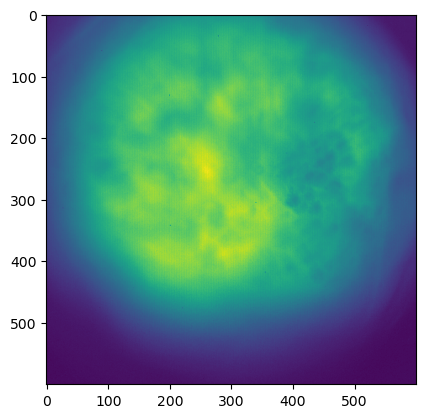

In [16]:
varr_min = varr_ref[frames_without_stripes].min("frame").compute()
plt.imshow(varr_min)

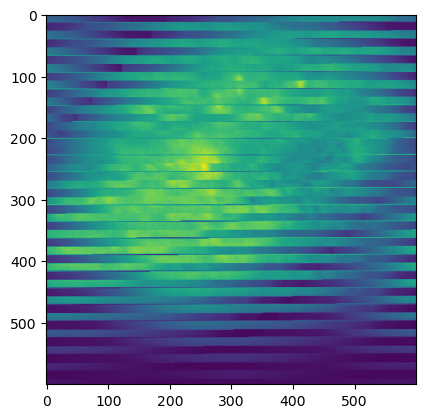

In [17]:
varr_min = varr_ref[bad_frames[0]]
plt.imshow(varr_min)

## get file names that need to be replaced

In [18]:


#def get_filename(frame_list):
#    # Get the file names associated with each frame. 
#    vid_numbers = np.unique([math.floor(f/framesPerFile) for f in frame_list])
#    fnames = [os.path.join(dpath, str(n) + '.avi') for n in vid_numbers]
    
    # Get the frame number within that video file. 
#    relative_frame_numbers = []
#    for n in vid_numbers:
#        quotient, remainder = np.divmod(frame_list, n*framesPerFile)
        
#        relative_frame_numbers.append(remainder[(quotient==1) & (remainder < framesPerFile)])
    
#    return fnames, relative_frame_numbers

In [19]:
def get_num_frames(video_file):
    # This function should return the number of frames in the given video file.
    # You can use any method you've previously used to determine the frame count.
    cap = cv2.VideoCapture(video_file)
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    cap.release()
    return frame_count

def get_filename(frame_list, param_load_videos=None):
    if not param_load_videos or "pattern" not in param_load_videos:
        pattern = r"[0-9]+\.avi$"
    else:
        pattern = param_load_videos["pattern"]
    
    all_files = natsorted([os.path.join(dpath, f) for f in os.listdir(dpath) if re.search(pattern, f)])

    # Assign start to None if not specified
    start = param_load_videos.get('start') if param_load_videos else None

    # Modify the list comprehension
    if start is not None:
        all_files = [f for f in all_files if int(re.search(r'(\d+)', os.path.basename(f)).group(1)) >= start]


    frames_per_file = [get_num_frames(f) for f in all_files]
    cumulative_frames = np.insert(np.cumsum(frames_per_file), 0, 0)

    grouped_frames = defaultdict(list)

    for frame in frame_list:
        idx = np.digitize(frame, cumulative_frames) - 1
        fname = all_files[idx]
        relative_frame = frame - cumulative_frames[idx]
        grouped_frames[fname].append(relative_frame)

    fnames = list(grouped_frames.keys())
    frame_numbers = list(grouped_frames.values())

    return fnames, frame_numbers


In [20]:
fnames, frame_numbers = get_filename(bad_frames, param_load_videos)
for fname, frames in zip(fnames, frame_numbers):
    print(f"File: {fname}, Bad Frames: {frames}")

File: /scratch/09117/xz6783/minian/Cat_Odor_Conflict/Sessions combined/2N6/16.avi, Bad Frames: [763, 764, 765, 766, 767, 768, 769, 770, 771, 772, 773, 774, 775, 776, 777, 778, 779, 780, 781, 782, 783, 784, 785, 786, 787, 788, 789, 790, 791, 792, 793, 794, 795, 796, 797, 798, 799, 800, 801, 802, 803, 804, 805, 806, 807, 808, 809, 810, 811, 812, 813, 814, 815, 816, 817, 818, 819, 820, 821, 822, 823, 824, 825, 826, 827, 828, 829, 830, 831, 832, 833, 834, 835, 836, 837, 838, 839, 840, 841, 842, 843, 844, 845, 846, 847, 848, 849, 850, 851, 852, 853, 854, 855, 856]
File: /scratch/09117/xz6783/minian/Cat_Odor_Conflict/Sessions combined/2N6/22.avi, Bad Frames: [935, 936, 937, 938, 939, 940]
File: /scratch/09117/xz6783/minian/Cat_Odor_Conflict/Sessions combined/2N6/23.avi, Bad Frames: [503, 504, 505, 506, 507, 508, 509, 510, 511, 512, 513, 514, 515, 516, 517, 518, 519, 520, 521, 522, 523, 524, 525, 526, 527, 528, 529, 530, 531, 532, 533, 534, 535, 536, 537, 538, 539, 540, 541, 542, 543, 544, 54

# Realignment

## move the original files to a new folder and then write a new file with fixed frames\

The function below makes a folder called "originals" and moves the original file there. Then it writes a new video file with the same name to replace it, but with the frames fixed. 

In [21]:
buffers= np.concatenate([np.arange(0, 360000, 8076), [360000]]).reshape(23,2)

def fix_frame_atypical(frame, ref_frame, buffers, exp_buffer_size=8076):
    fm_flatten = frame.flatten().astype(float)
    fm_ref_flatten = ref_frame.flatten().astype(float)
    shifts = np.zeros(buffers.shape[0])
    fm_fix = fm_flatten.copy()
    for ibuf, buf in enumerate(buffers):
        a, b = buf
        fm_fix[a:b] = 0
        cur_buf = fm_flatten[a:b]
        cur_ref = fm_ref_flatten[a:b]
        cur_new, cur_mask, sh = shift_buffer(fm_fix[a:b], cur_buf, cur_ref)
        fm_fix[a:b] = cur_new
        idx_missing = np.where(~cur_mask)[0]
        c, d = a + idx_missing.min(), a + idx_missing.max()
        len_missing = d - c
        shifts[ibuf] = sh
        if ibuf > 0:
            j, k = buffers[ibuf - 1]
            assert (k - j) > len_missing
            prev_buf = fm_flatten[(k - len_missing) : k]
            prev_new, prev_mask, sh = shift_buffer(
                cur_new[~cur_mask], prev_buf, cur_ref[~cur_mask]
            )
            fm_fix[c : (d + 1)] = prev_new
    return fm_fix.reshape(frame.shape).astype(frame.dtype)


def shift_buffer(buf_org, buf_repl, buf_ref):
    std_ref = np.std(buf_ref)
    std_repl = np.std(buf_repl)
    if std_ref > 0 and std_repl > 0:
        ref_norm = (buf_ref - buf_ref.mean()) / std_ref
        repl_norm = (buf_repl - buf_repl.mean()) / std_repl
        lags = correlation_lags(len(buf_repl), len(buf_ref), mode="full")
        corr = correlate(repl_norm, ref_norm, mode="full", method="fft")
        sh = -lags[np.argmax(corr)]
    else:
        sh = 0
    len_repl = len(buf_repl) - abs(sh)
    buf_new = buf_org.copy()
    mask = np.zeros_like(buf_org, dtype=bool)
    range_repl = np.arange(max(0, sh), min(len(buf_repl) + sh, len(buf_new)))
    buf_new[range_repl] = buf_repl[range_repl - sh]
    mask[range_repl] = 1
    return buf_new, mask, sh


def shift_direction(frame, ref_frame):
    fm_flt = frame.flatten().astype(float)
    ref_flt = ref_frame.flatten().astype(float)
    lags = correlation_lags(len(fm_flt), len(ref_flt), mode="full")
    corr = correlate(fm_flt, ref_flt, mode="full", method="fft")
    sh = lags[np.argmax(corr)]
    return sh



def fix_frame(frame, ref_frame, buffers, shift, shift_amount=2*8076, show_plot=False, ax=None):
    
    Fframe = frame.flatten()
    Fref_frame = ref_frame.flatten()
    frame_size = frame.shape
    
    #determine direction of shift
    direc = -1
    if  600 > shift > 0:
        direc = 1

    
    # Extract all buffers
    all_buffers = [Fframe[start:end] for start, end in buffers]
    concatenated_buffer = np.concatenate(all_buffers)

    # Circularly shift the concatenated_buffer to start from the second buffer
    shift_amount = len(all_buffers[0])
    circular_shifted_buffer = np.roll(concatenated_buffer, direc*shift_amount)

    # Initialize the new array with zeros
    fixed_frame = Fframe.copy()

    # Fill the buffers in the new array using the circularly shifted buffer
    concatenated_buffer_index = 0
    for start, end in buffers:
        buffer_size = end - start
        fixed_frame[start:end] = circular_shifted_buffer[concatenated_buffer_index:concatenated_buffer_index+buffer_size]
        concatenated_buffer_index += buffer_size

    fixed_frame = fixed_frame.reshape(frame.shape).astype(frame.dtype)
    
    if show_plot:
        if ax is None:
            fig, ax = plt.subplots(figsize=(24,24))
        ax.imshow(fixed_frame)
    
    return fixed_frame 


In [22]:
# def fix_frame(frame, shift_amount=8076*2, show_plot=False, ax=None):
#     buffer_size = 8076
#     flattened_frame = frame.flatten()
#     frame_size = frame.shape
#     n_pixels = len(flattened_frame)
    
#     for pixel_number in range(n_pixels):
#         buf_num = int(pixel_number/buffer_size)
        
#         if ((buf_num % 2) == 0):
#             if ((pixel_number + shift_amount) < n_pixels):
#                 flattened_frame[pixel_number] = flattened_frame[pixel_number + shift_amount]
    
#     fixed_frame = flattened_frame.reshape(frame_size)
    
#     if show_plot:
#         if ax is None:
#             fig, ax = plt.subplots(figsize=(24,24))
#         ax.imshow(fixed_frame)
    
#     return fixed_frame

def fix_video(fnames, frame_numbers):
    folder = os.path.join(os.path.split(fnames[0])[0], 'originals')
    if not os.path.exists(folder):
        os.mkdir(folder)
        print(f'Created {folder}')
        
    compressionCodec = "GREY"
    codec = cv2.VideoWriter_fourcc(*compressionCodec)
    
    #reference frame 
    ref_frame = varr_ref[bad_frames[0]-1].values
    
    buffer_size = 8076
    shift_amount = buffer_size*2
    
    # For each video...
    for video, bad_frame_numbers in zip(fnames, frame_numbers):
        print(f'Rewriting {video}')
        cap = cv2.VideoCapture(video)
        rows, cols = int(cap.get(4)), int(cap.get(3))
        
        fname = os.path.split(video)[1]
        move_fpath = os.path.join(folder, fname)
        
        # Move the original file. 
        if not os.path.exists(move_fpath):
            shutil.move(video, move_fpath)
            print(f'Moved {video} to {move_fpath}')
        else:
            raise FileExistsError('The folder is already storing an original file. Aborting to prevent overwrite.')

        writeFile = cv2.VideoWriter(video, codec, 60, (cols,rows), isColor=False)
        
        for frame_number in tqdm(range(int(cap.get(7)))):
            ret, frame = cap.read()

            if ret:
                write_frame = frame[:,:,0]

                if frame_number in bad_frame_numbers:
                    shift = shift_direction(write_frame, ref_frame)
                    if shift>20 or shift <= -20:
                        write_frame = fix_frame(write_frame, ref_frame, buffers, shift, shift_amount, show_plot=False)
#                     elif 0<shift<=4 or shift==12:
#                         write_frame = fix_frame_atypical(write_frame, ref_frame, buffers)
                    else:
                        write_frame = ref_frame

                writeFile.write(np.uint8(write_frame))
            else:
                break

        writeFile.release()
        cap.release()
    cv2.destroyAllWindows()
                

In [23]:
def shift_direction(frame, ref_frame):
    fm_flt = frame.flatten().astype(float)
    ref_flt = ref_frame.flatten().astype(float)
    lags = correlation_lags(len(fm_flt), len(ref_flt), mode="full")
    corr = correlate(fm_flt, ref_flt, mode="full", method="fft")
    sh = lags[np.argmax(corr)]
    return sh

   
#reference frame 
ref_frame = varr_ref[bad_frames[0]-1].values

directions = []

# For each video...
for video, bad_frame_numbers in zip(fnames, frame_numbers):
    cap = cv2.VideoCapture(video)
    rows, cols = int(cap.get(4)), int(cap.get(3))

    fname = os.path.split(video)[1]

    for frame_number in tqdm(range(int(cap.get(7)))):
        ret, frame = cap.read()

        if ret:
            write_frame = frame[:,:,0]

            if frame_number in bad_frame_numbers:
                directions.append(shift_direction(write_frame, ref_frame))

        else:
            break

    cap.release()
cv2.destroyAllWindows()
directions

100%|██████████| 1000/1000 [00:01<00:00, 754.87it/s]


[0,
 0,
 4,
 4,
 0,
 0,
 0,
 0,
 -4,
 0,
 0,
 4,
 20,
 24,
 24,
 24,
 24,
 24,
 24,
 24,
 24,
 24,
 24,
 24,
 24,
 24,
 24,
 24,
 24,
 24,
 24,
 24,
 24,
 24,
 24,
 24,
 24,
 24,
 24,
 24,
 24,
 24,
 24,
 24,
 24,
 24,
 24,
 24,
 24,
 24,
 24,
 24,
 24,
 24,
 24,
 24,
 24,
 24,
 24,
 24,
 24,
 24,
 24,
 24,
 24,
 24,
 24,
 24,
 24,
 24,
 24,
 24,
 24,
 24,
 24,
 24,
 24,
 24,
 24,
 24,
 24,
 24,
 24,
 24,
 24,
 24,
 24,
 24,
 24,
 24,
 24,
 24,
 24,
 24,
 12,
 4,
 0,
 0,
 0,
 0,
 4,
 0,
 -4,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 8,
 8,
 0,
 -8,
 24,
 24,
 24,
 24,
 24,
 24,
 24,
 24,
 24,
 24,
 24,
 24,
 24,
 24,
 24,
 24,
 24,
 24,
 24,
 24,
 24,
 24,
 24,
 24,
 24,
 24,
 24,
 24,
 24,
 24,
 8,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 6,
 12,
 8,
 0,
 24,
 24,
 24,
 24,
 24,
 24,
 24,
 24,
 24,
 24,
 24,
 24,
 24,
 24,
 24,
 24,
 24,
 24,
 24,
 24,
 24,
 24,
 24,
 24]

In [24]:
directions = np.array(directions)
directions

array([ 0,  0,  4,  4,  0,  0,  0,  0, -4,  0,  0,  4, 20, 24, 24, 24, 24,
       24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24,
       24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24,
       24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24,
       24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24,
       24, 24, 24, 24, 24, 24, 24, 24, 24, 12,  4,  0,  0,  0,  0,  4,  0,
       -4,  0,  0,  0,  0,  0,  0,  0,  0,  8,  8,  0, -8, 24, 24, 24, 24,
       24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24,
       24, 24, 24, 24, 24, 24, 24, 24, 24,  8,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  6, 12,  8,  0, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24,
       24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24])

In [25]:
fix_video(fnames, frame_numbers)

Rewriting /scratch/09117/xz6783/minian/Cat_Odor_Conflict/Sessions combined/2N6/16.avi
Moved /scratch/09117/xz6783/minian/Cat_Odor_Conflict/Sessions combined/2N6/16.avi to /scratch/09117/xz6783/minian/Cat_Odor_Conflict/Sessions combined/2N6/originals/16.avi


100%|██████████| 1000/1000 [00:04<00:00, 226.90it/s]


Rewriting /scratch/09117/xz6783/minian/Cat_Odor_Conflict/Sessions combined/2N6/22.avi
Moved /scratch/09117/xz6783/minian/Cat_Odor_Conflict/Sessions combined/2N6/22.avi to /scratch/09117/xz6783/minian/Cat_Odor_Conflict/Sessions combined/2N6/originals/22.avi


100%|██████████| 1000/1000 [00:01<00:00, 669.12it/s]


Rewriting /scratch/09117/xz6783/minian/Cat_Odor_Conflict/Sessions combined/2N6/23.avi
Moved /scratch/09117/xz6783/minian/Cat_Odor_Conflict/Sessions combined/2N6/23.avi to /scratch/09117/xz6783/minian/Cat_Odor_Conflict/Sessions combined/2N6/originals/23.avi


100%|██████████| 1000/1000 [00:02<00:00, 353.58it/s]


Rewriting /scratch/09117/xz6783/minian/Cat_Odor_Conflict/Sessions combined/2N6/29.avi
Moved /scratch/09117/xz6783/minian/Cat_Odor_Conflict/Sessions combined/2N6/29.avi to /scratch/09117/xz6783/minian/Cat_Odor_Conflict/Sessions combined/2N6/originals/29.avi


100%|██████████| 1000/1000 [00:01<00:00, 625.17it/s]


Rewriting /scratch/09117/xz6783/minian/Cat_Odor_Conflict/Sessions combined/2N6/30.avi
Moved /scratch/09117/xz6783/minian/Cat_Odor_Conflict/Sessions combined/2N6/30.avi to /scratch/09117/xz6783/minian/Cat_Odor_Conflict/Sessions combined/2N6/originals/30.avi


100%|██████████| 1000/1000 [00:01<00:00, 557.07it/s]


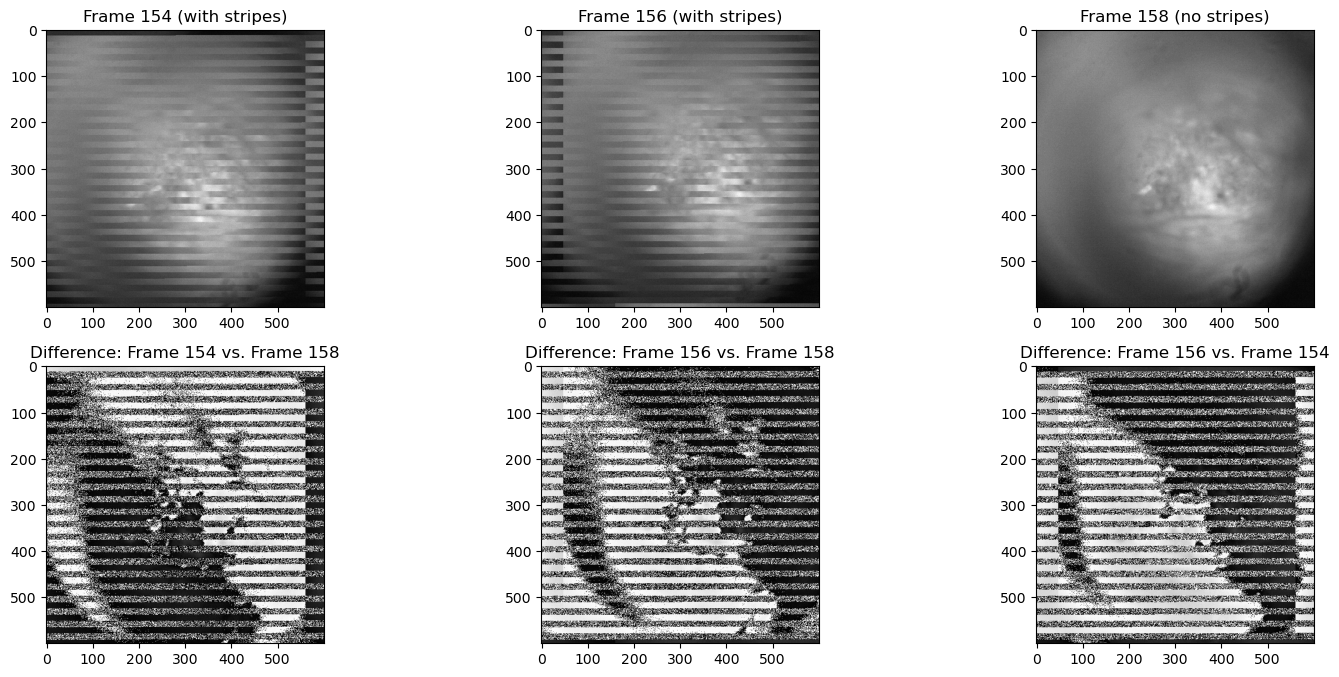

In [269]:
# # Plot the frames and their differences
# plt.figure(figsize=(15, 10))

# # Frame 1000
# plt.subplot(3, 3, 1)
# plt.imshow(varr_ref[154].values, cmap='gray')
# plt.title('Frame 154 (with stripes)')

# # Frame 68
# plt.subplot(3, 3, 2)
# plt.imshow(varr_ref[156].values, cmap='gray')
# plt.title('Frame 156 (with stripes)')

# # Frame 67
# plt.subplot(3, 3, 3)
# plt.imshow(varr_ref[158].values, cmap='gray')
# plt.title('Frame 158 (no stripes)')

# # Difference: Frame 999 vs. Frame 68
# plt.subplot(3, 3, 4)
# plt.imshow(np.abs(varr_ref[154].values - varr_ref[158].values), cmap='gray')
# plt.title('Difference: Frame 154 vs. Frame 158')

# # Difference: Frame 1000 vs. Frame 67
# plt.subplot(3, 3, 5)
# plt.imshow(np.abs(varr_ref[156].values - varr_ref[158].values), cmap='gray')
# plt.title('Difference: Frame 156 vs. Frame 158')

# # Difference: Frame 68 vs. Frame 67
# plt.subplot(3, 3, 6)
# plt.imshow(np.abs(varr_ref[156].values - varr_ref[154].values), cmap='gray')
# plt.title('Difference: Frame 156 vs. Frame 154')

# plt.tight_layout()
# plt.show()


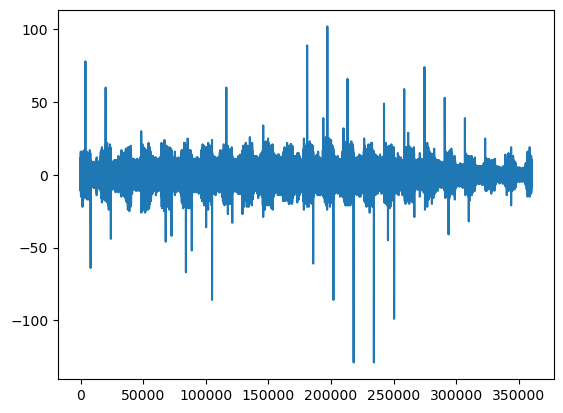

In [80]:
# write_frame = varr_ref[bad_frames[6]].values
# ref_frame = varr_ref[bad_frames[0]-1].values
# fm_flt = write_frame.flatten().astype(float)
# ref_flt = ref_frame.flatten().astype(float)
# diff_fm = np.abs(fm_flt - ref_flt)
# plt.plot(np.diff(diff_fm))


In [169]:
# # Refining Buffer Construction
# def generate_refined_buffers(write_frame, ref_frame, window_size = 8076*2, init_thresh = 2, exp_buffer_size=8076, 
#                               frame_limit=600*600, deviation=100, search_range=20):
    
#     fm_flt = write_frame.flatten().astype(float)
#     ref_flt = ref_frame.flatten().astype(float)
#     fm_size = len(fm_flt)
#     fm_diff = np.abs(np.diff(fm_flt))
#     diff_fm = np.abs(fm_flt - ref_flt)
#     diff_fm_diff = moving_avg(savgol_filter(np.diff(diff_fm), 30, 4), 16200)
    
#     #Find anchors 
#     anchors, anchors_initial = find_dynamic_anchors(write_frame, ref_frame)
    
#     # Initialize variables
#     initial_buffers = []
    
#     #expected strips 
#     expected_strips=math.ceil(len(write_frame.flatten())/window_size)
    
#     # Start with the first buffer point as 0
#     current_point = 0

#     # Loop through expected number of strips
#     for _ in range(expected_strips):
#         # Look for a potential anchor within a specific range around exp_buffer_size
#         search_start = current_point + exp_buffer_size - search_range
#         search_end = current_point + exp_buffer_size + search_range

#         potential_anchors = [anchor for anchor in anchors if search_start <= anchor <= search_end]

#         # If an anchor is found within the range
#         if potential_anchors:
#             # Replace end point with anchor
#             end_point = potential_anchors[0]
#             # Find the corresponding entries in anchors_initial 
#             indices = np.where(anchors_initial == potential_anchors[0])[0]
#             if indices.size > 0 and indices[0] + 1 < len(anchors_initial):
#                 next_start = anchors_initial[indices[0] + 1]
#         else:
#             # Define end_point as current_point += exp_buffer_size
#             # Additionally Check if the last buffer could exceed frame limit
#             end_point = min(current_point + exp_buffer_size, frame_limit - 1)
#             next_start = end_point + exp_buffer_size
 
#         # Add current buffer to the list
#         initial_buffers.append((current_point, end_point))

#         # Update current_point for the next iteration
#         current_point = next_start
        
#     refined_buffers = np.array(initial_buffers).copy()
    
#     #Expand dynamic_thresh
#     dynamic_thresh_diff_fm = compute_thresholds(diff_fm, init_thresh)
#     dynamic_thresh_diff_fm = savgol_filter(dynamic_thresh_diff_fm, 8000,1)
    
#     # Additional buffer refinement using diff_fm 
#     if diff_fm is not None:
#         for idxbuf, buf in np.ndenumerate(refined_buffers):
#             """ OLD IMPLEMENTATION:
            
#             idx = np.arange(
#                 max(buf - search_range, 0), min(buf + search_range, fm_size - 2)
#             )
#             diffs = diff_fm[idx]
#             if len(idx) > 0 and ((max(diffs) - min(diffs)) > 0):
#                 refined_buffers[idxbuf] = idx[np.argmax(diffs)] + 1

#             """

#             # Define the search area
#             search_start = max(buf - search_range, 0)
#             search_end = min(buf + search_range, frame_limit - 1)
        
#             # Define local threshold
#             local_thresh = dynamic_thresh_diff_fm[search_start: search_end]
            
#             # The indicies that meet the threshold criteria
#             candidate_indicies = np.where(diff_fm[search_start: search_end] >= local_thresh)[0]
            
#             # Fix offset to match original diff_fm
#             candidate_indicies += search_start

#             if idxbuf[1] % 2 == 0 and idxbuf[1] != 0:
#                 # Set as first pixel that reaches threshold for start of buffer, except for first buffer
#                     if candidate_indicies.any():
#                         refined_buffers[idxbuf] = candidate_indicies[0]
#             elif idxbuf[1] % 2 != 0 and idxbuf[1] != 0:
#                 # Set as last pixel that reaches threshold for end of buffer
#                 if candidate_indicies.any():
#                     refined_buffers[idxbuf] = candidate_indicies[-1]
        
    
#     return refined_buffers

# buffers = generate_refined_buffers(write_frame, ref_frame)
# buffers

array([[     0,   8079],
       [ 16159,  24235],
       [ 32311,  40374],
       [ 48463,  56539],
       [ 64615,  72691],
       [ 80767,  88843],
       [ 96919, 104999],
       [113071, 121151],
       [129223, 137303],
       [145375, 153451],
       [161527, 169607],
       [177679, 185759],
       [193831, 201911],
       [209983, 218062],
       [226143, 234210],
       [242295, 250367],
       [258447, 266518],
       [274599, 282662],
       [290751, 298822],
       [306903, 314983],
       [323055, 331115],
       [339207, 347283],
       [355359, 359998]])

In [85]:

# def fix_frame(frame, ref_frame, buffers, exp_buffer_size=8076):
#     fm_flatten = frame.flatten().astype(float)
#     fm_ref_flatten = ref_frame.flatten().astype(float)
#     shifts = np.zeros(buffers.shape[0])
#     fm_fix = fm_flatten.copy()
#     for ibuf, buf in enumerate(buffers):
#         a, b = buf
#         fm_fix[a:b] = 0
#         cur_buf = fm_flatten[a:b]
#         cur_ref = fm_ref_flatten[a:b]
#         cur_new, cur_mask, sh = shift_buffer(fm_fix[a:b], cur_buf, cur_ref)
#         fm_fix[a:b] = cur_new
#         idx_missing = np.where(~cur_mask)[0]
#         c, d = a + idx_missing.min(), a + idx_missing.max()
#         len_missing = d - c
#         shifts[ibuf] = sh
#         if ibuf > 0:
#             j, k = buffers[ibuf - 1]
#             assert (k - j) > len_missing
#             prev_buf = fm_flatten[(k - len_missing) : k]
#             prev_new, prev_mask, sh = shift_buffer(
#                 cur_new[~cur_mask], prev_buf, cur_ref[~cur_mask]
#             )
#             fm_fix[c : (d + 1)] = prev_new
#     return fm_fix.reshape(frame.shape).astype(frame.dtype), shifts


# def shift_buffer(buf_org, buf_repl, buf_ref):
#     std_ref = np.std(buf_ref)
#     std_repl = np.std(buf_repl)
#     if std_ref > 0 and std_repl > 0:
#         ref_norm = (buf_ref - buf_ref.mean()) / std_ref
#         repl_norm = (buf_repl - buf_repl.mean()) / std_repl
#         lags = correlation_lags(len(buf_repl), len(buf_ref), mode="full")
#         corr = correlate(repl_norm, ref_norm, mode="full", method="fft")
#         sh = -lags[np.argmax(corr)]
#     else:
#         sh = 0
#     len_repl = len(buf_repl) - abs(sh)
#     buf_new = buf_org.copy()
#     mask = np.zeros_like(buf_org, dtype=bool)
#     range_repl = np.arange(max(0, sh), min(len(buf_repl) + sh, len(buf_new)))
#     buf_new[range_repl] = buf_repl[range_repl - sh]
#     mask[range_repl] = 1
#     return buf_new, mask, sh

# fixed_frame, shifts = fix_frame(varr_ref[bad_frames[np.where(directions== (9))[0][0]]].values,varr_ref[bad_frames[0]-1].values, buffers)

array([-1972., -1948., -1924., -1900., -1868., -1852., -1840., -1812.,
       -1792., -1768., -1744., -1728., -1696., -1676., -1656., -1632.,
       -1608., -1580., -1552., -1532., -1508., -1480., -1560.])

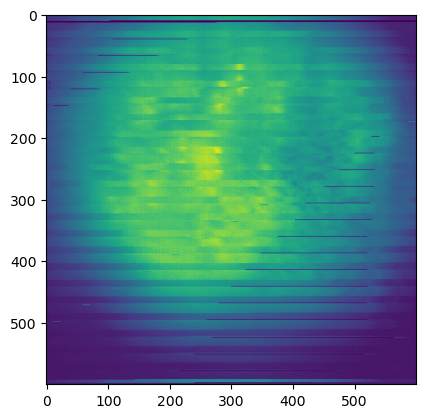

In [89]:
# plt.imshow(fixed_frame)
# shifts

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

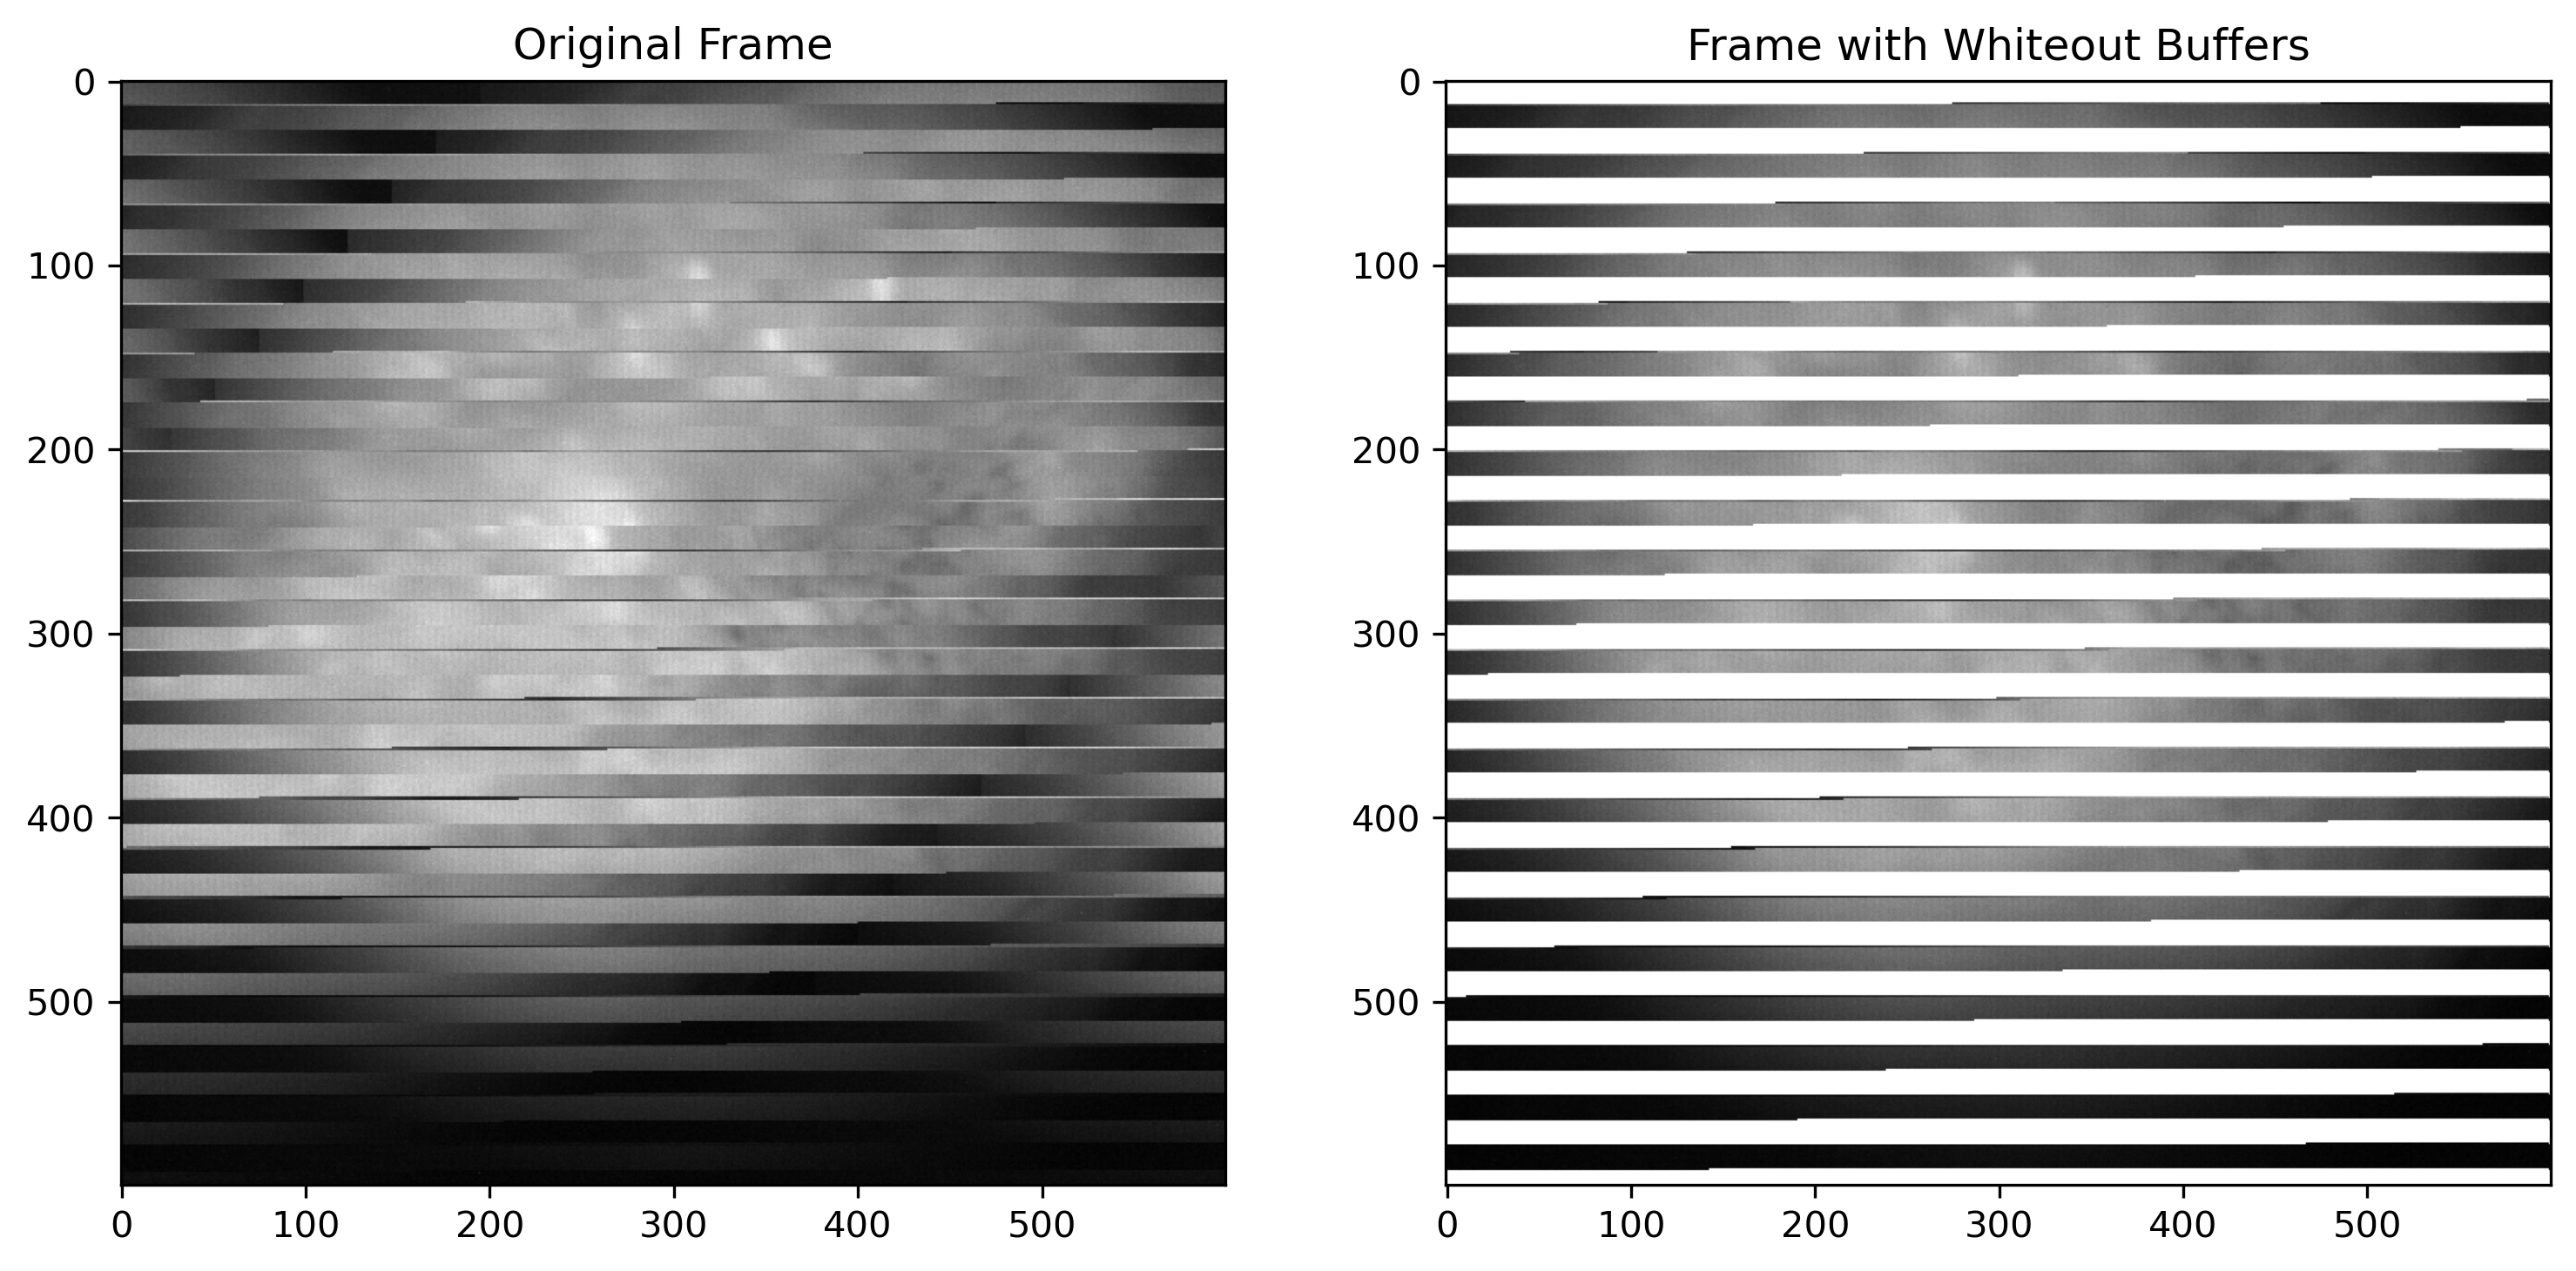

In [555]:
# def visualize_all_buffers(frame, buffers):
#     """
#     Visualize all buffers on the original frame.

#     Parameters:
#     - frame: 2D array representing the frame.
#     - buffers: Array of shape (N, 2) where each row contains the start and end indices of a buffer.

#     Returns:
#     - vis_frame: Frame with all buffers highlighted.
#     """
#     vis_frame = frame.copy()
#     rows, cols = frame.shape

#     # Convert flattened indices to 2D coordinates
#     def idx_to_2d(idx):
#         return divmod(idx, cols)

#     # Highlight each buffer region
#     for start, end in buffers:
#         for idx in range(start, end):
#             row, col = idx_to_2d(idx)
#             vis_frame[row-1, col-1] = 255  # Set to white for visualization

#     # Display the frame with all highlighted buffers
#     # Plot the original and modified frames
#     plt.figure(figsize=(12, 6), dpi = 300)
    
#     plt.subplot(1, 2, 1)
#     plt.imshow(frame, cmap='gray')
#     plt.title("Original Frame")
    
#     plt.subplot(1, 2, 2)
#     plt.imshow(vis_frame, cmap='gray')
#     plt.title("Frame with Whiteout Buffers")

#     return vis_frame

# # Assuming you have already determined the buffers for a frame and have a frame named 'write_frame'
# visualize_all_buffers(varr_ref[bad_frames[0]].values, buffers)



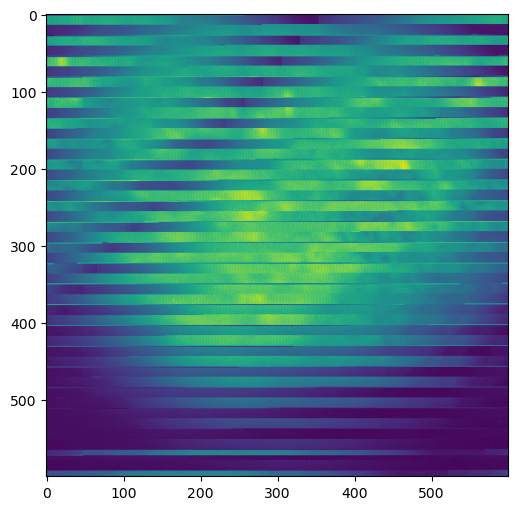

In [813]:
# #Original code from Will


# # # For each video...
# # for video, bad_frame_numbers in zip(fnames, frame_numbers):
# #     print(f'Rewriting {video}')
# #     cap = cv2.VideoCapture(video)
# #     rows, cols = int(cap.get(4)), int(cap.get(3))
    
# cap = cv2.VideoCapture(fnames[0])
# # Set the position to the 68th frame
# cap.set(cv2.CAP_PROP_POS_FRAMES, 774)

# # Read the frame
# ret, frame = cap.read()

# write_frame = frame[:,:,0]
# show_plot = True
# buffer_size = 8076
# shift_amount=buffer_size*2
# bufNum = 0
# frame = write_frame
# flattened_frame = frame.flatten()
# frame_size = frame.shape
# n_pixels = len(flattened_frame)

# for pixel_number in range(n_pixels):
#     buf_num = int(pixel_number/buffer_size)

#     if ((buf_num % 2) == 0):
#         if ((pixel_number + shift_amount) < n_pixels):
#             flattened_frame[pixel_number] = flattened_frame[pixel_number + shift_amount]

# fixed_frame = flattened_frame.reshape(frame_size)

# if show_plot:
   
#     fig, ax = plt.subplots(figsize=(6,6))
#     ax.imshow(fixed_frame)

In [790]:
# buffers = np.concatenate([np.arange(0, 360000, 8076), [360000]]).reshape(23,2)
# # buffers = np.delete(buffers,8,0)
# # buffers = buffers[9:]
# # len(buffers)

In [102]:
# size = 8076
# buffers = np.concatenate([np.arange(0, 360000, size), [360000]]).reshape(23,2)


# # Extract all buffers
# frame = varr_ref[bad_frames[20]].values
# Fframe = frame.flatten()

# all_buffers = [Fframe[start:end] for start, end in buffers]
# concatenated_buffer = np.concatenate(all_buffers)

# # Circularly shift the concatenated_buffer to start from the second buffer
# shift_amount = len(all_buffers[0])
# circular_shifted_buffer = np.roll(concatenated_buffer, shift_amount)

# # Initialize the new array with zeros
# new_frame = Fframe.copy()

# # Fill the buffers in the new array using the circularly shifted buffer
# concatenated_buffer_index = 0
# for start, end in buffers:
#     buffer_size = end - start
#     new_frame[start:end] = circular_shifted_buffer[concatenated_buffer_index:concatenated_buffer_index+buffer_size]
#     concatenated_buffer_index += buffer_size



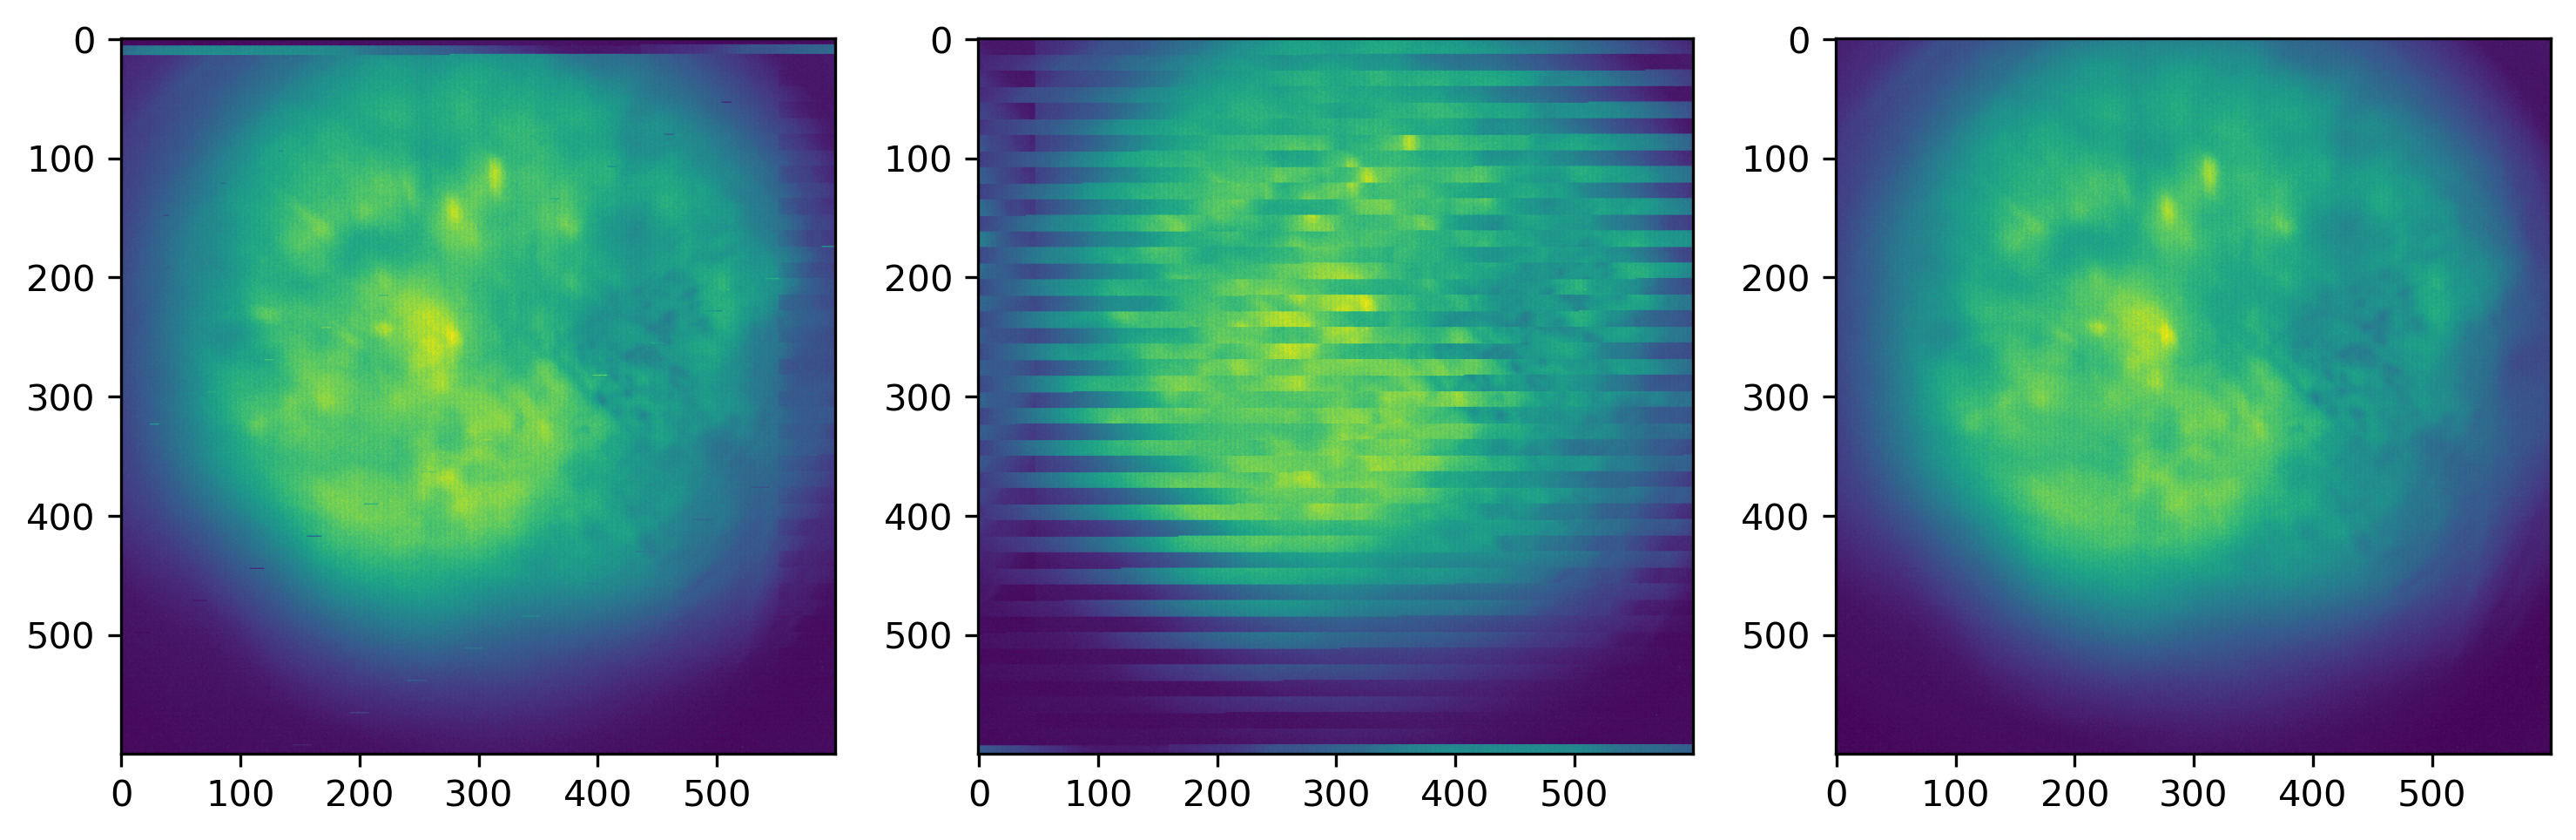

In [103]:
# plt.figure(figsize=(12, 6), dpi = 300)

# plt.subplot(1, 3, 1)
# plt.imshow(new_frame.reshape(frame.shape).astype(frame.dtype))
# plt.subplot(1, 3, 2)
# plt.imshow(frame)
# plt.subplot(1, 3, 3)
# plt.imshow(varr_ref[bad_frames[0]-1])
# plt.show()

# Further corrections

At this point, inspect the new videos and compare them to the ones in the "original" folder. If the new ones look pristine, you're done! Skip the remaining steps and proceed to Minian.

If the new videos still have stripes, you have no choice but to replace those frames with the most recent good frame. Usually these stripes are "nonstationary", as in they sweep across the image rather than being static. I haven't figured out how to correct these, so the workaround is to replace them with the most recent good frame. Proceed ahead. 

In [26]:
dpath = '/scratch/09117/xz6783/minian/Cat_Odor_Conflict/Sessions combined/2N6'

In [27]:
%%time
# Reload the whole again movie. Make sure you replaced the files with the repaired ones!! 
varr_new = load_videos(dpath, **param_load_videos)

loading 56 videos in folder /scratch/09117/xz6783/minian/Cat_Odor_Conflict/Sessions combined/2N6
CPU times: user 217 ms, sys: 509 ms, total: 726 ms
Wall time: 2 s


In [28]:
varr_ref_new = varr_new.chunk({"frame": 20, "height": -1, "width": -1})
varr_ref_new = varr_ref_new.persist()

ffmpeg version N-112380-gc7fb4d0eb6 Copyright (c) 2000-2023 the FFmpeg developers
  built with gcc 9.4.0 (GCC)
  configuration: --prefix=/work/09117/xz6783/ls6/ffmpeg --pkg-config-flags=--static --extra-cflags=-I/work/09117/xz6783/ls6/ffmpeg/include --extra-ldflags=-L/work/09117/xz6783/ls6/ffmpeg/lib --extra-libs='-lpthread -lm' --enable-gpl --enable-libfdk_aac --enable-libfreetype --enable-libmp3lame --enable-libvpx --enable-libx264 --enable-libx265 --enable-nonfree
  libavutil      58. 27.100 / 58. 27.100
  libavcodec     60. 30.101 / 60. 30.101
  libavformat    60. 15.100 / 60. 15.100
  libavdevice    60.  2.101 / 60.  2.101
  libavfilter     9. 11.100 /  9. 11.100
  libswscale      7.  4.100 /  7.  4.100
  libswresample   4. 11.100 /  4. 11.100
  libpostproc    57.  2.100 / 57.  2.100
ffmpeg version N-112380-gc7fb4d0eb6ffmpeg version N-112380-gc7fb4d0eb6 Copyright (c) 2000-2023 the FFmpeg developers Copyright (c) 2000-2023 the FFmpeg developers

  built with gcc 9.4.0 (GCC)
  confi

Output #0, rawvideo, to 'pipe:':
  Metadata:
    software        : Lavf58.29.100
    encoder         : Lavf60.15.100
  Stream #0:0: Video: rawvideo (Y800 / 0x30303859), gray(progressive), 600x600, q=2-31, 172800 kb/s, 60 fps, 60 tbn
    Metadata:
      encoder         : Lavc60.30.101 rawvideo
Output #0, rawvideo, to 'pipe:':      0kB time=N/A bitrate=N/A speed=N/A    
  Metadata:
    software        : Lavf58.29.100
    encoder         : Lavf60.15.100
  Stream #0:0: Video: rawvideo (Y800 / 0x30303859), gray(progressive), 600x600, q=2-31, 172800 kb/s, 60 fps, 60 tbn
    Metadata:
      encoder         : Lavc60.30.101 rawvideo
Output #0, rawvideo, to 'pipe:':
  Metadata:
    software        : Lavf58.29.100
    encoder         : Lavf60.15.100
Output #0, rawvideo, to 'pipe:':
  Stream #0:0: Video: rawvideo (Y800 / 0x30303859), gray(progressive), 600x600, q=2-31, 172800 kb/s  Metadata:
,     software        : 60 fps, Lavf58.29.10060 tbn

    Metadata:
    encoder         :       encoder     

[out#0/rawvideo @ 0x505a080] video:351562kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.000000%
frame= 1000 fps=459 q=-0.0 Lsize=  351562kB time=00:00:16.65 bitrate=172973.0kbits/s speed=7.64x    
ffmpeg version N-112380-gc7fb4d0eb6 Copyright (c) 2000-2023 the FFmpeg developers
  built with gcc 9.4.0 (GCC)
  configuration: --prefix=/work/09117/xz6783/ls6/ffmpeg --pkg-config-flags=--static --extra-cflags=-I/work/09117/xz6783/ls6/ffmpeg/include --extra-ldflags=-L/work/09117/xz6783/ls6/ffmpeg/lib --extra-libs='-lpthread -lm' --enable-gpl --enable-libfdk_aac --enable-libfreetype --enable-libmp3lame --enable-libvpx --enable-libx264 --enable-libx265 --enable-nonfree
  libavutil      58. 27.100 / 58. 27.100
  libavcodec     60. 30.101 / 60. 30.101
  libavformat    60. 15.100 / 60. 15.100
  libavdevice    60.  2.101 / 60.  2.101
  libavfilter     9. 11.100 /  9. 11.100
  libswscale      7.  4.100 /  7.  4.100
  libswresample   4. 11.100 /  4. 11.100
  libpost

Stream mapping:
  Stream #0:0 -> #0:0 (rawvideo (native) -> rawvideo (native))
Press [q] to stop, [?] for help
Stream mapping:
  Stream #0:0 -> #0:0 (rawvideo (native) -> rawvideo (native))
Press [q] to stop, [?] for help
Output #0, rawvideo, to 'pipe:':
  Metadata:
    software        : Lavf58.29.100
    encoder         : Lavf60.15.100
  Stream #0:0: Video: rawvideo (Y800 / 0x30303859), gray(progressive), 600x600, q=2-31, 172800 kb/s, 60 fps, 60 tbn
    Metadata:
      encoder         : Lavc60.30.101 rawvideo
Input #0, avi, from '/scratch/09117/xz6783/minian/Cat_Odor_Conflict/Sessions combined/2N6/9.avi':
  Metadata:
    software        : Lavf58.29.100
  Duration: 00:00:16.67, start: 0.000000, bitrate: 172818 kb/s
  Stream #0:0: Video: rawvideo (GREY / 0x59455247), gray, 600x600, 172972 kb/s, 60 fps, 60 tbr, 60 tbn
Output #0, rawvideo, to 'pipe:':      0kB time=N/A bitrate=N/A speed=N/A    
  Metadata:
    software        : Lavf58.29.100
    encoder         : Lavf60.15.100
  Stream #0

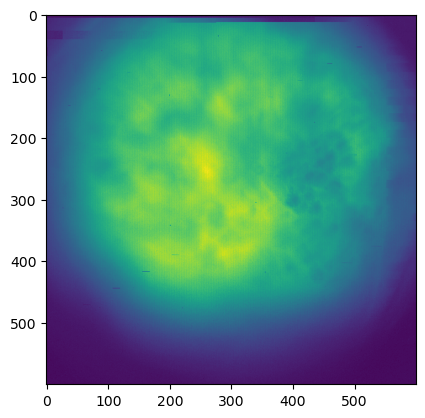

In [29]:
varr_min = varr_ref_new.min("frame").compute()
plt.imshow(varr_min)

In [159]:
np.where(directions==12)

(array([ 94, 157]),)

In [120]:
directions

array([ 0,  0,  4,  4,  0,  0,  0,  0, -4,  0,  0,  4, 20, 24, 24, 24, 24,
       24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24,
       24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24,
       24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24,
       24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24,
       24, 24, 24, 24, 24, 24, 24, 24, 24, 12,  4,  0,  0,  0,  0,  4,  0,
       -4,  0,  0,  0,  0,  0,  0,  0,  0,  8,  8,  0, -8, 24, 24, 24, 24,
       24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24,
       24, 24, 24, 24, 24, 24, 24, 24, 24,  8,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  6, 12,  8,  0, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24,
       24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24])

In [47]:
np.where(bad_frames==16769)

(array([6]),)

12

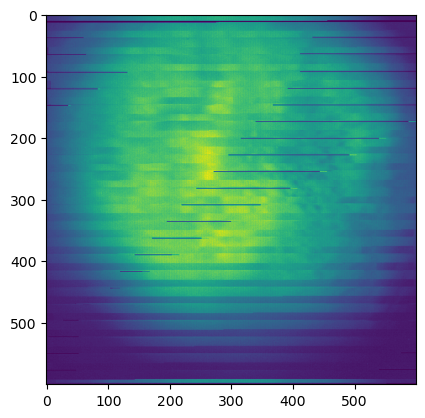

In [161]:
num = 157
plt.imshow(varr_ref_new[bad_frames[num]].values)
directions[num]

In [ ]:
# varr_ref = sensor_denoise(varr_ref, n=5, y=2)
# min_val = varr_ref.min().compute()
# max_val = varr_ref.max().compute()
# varr_ref = ((varr_ref - min_val) / (max_val - min_val) * 255)
# varr_ref = varr_ref.astype(np.uint8)

## Look for striped frames again

In [192]:
frames_without_stripes = no_stripes_frames(varr_ref).values
bad_frames = np.asarray(varr_ref[~frames_without_stripes].frame)
bad_frames

array([  68,   69,   70, ..., 8154, 8155, 8156])

In [ ]:
# Inspect frames by eye and optionally, save the frames to a folder.

def plot_bad_frame(bad_frame, save=False, show_plot=False, dpath=dpath):
    x = varr_ref.sel(frame=bad_frame)
    f, Pxx_spec = periodogram(x[:,0], 1)
    peaks = find_peaks(np.sqrt(Pxx_spec)[:int(len(Pxx_spec)/5)], height=20)[0]
    fig, ax = plt.subplots(ncols=2, figsize=(40,10))
    ax[0].imshow(x, cmap='binary_r', aspect='equal', origin='lower')
    ax[1].semilogy(f, np.sqrt(Pxx_spec), c='k')
    ax[1].scatter(f[peaks], np.sqrt(Pxx_spec)[peaks], s=100, c='brown')
    if len(peaks) > 1:
        ax[1].text(x = 0.01, y = 0.1, s='Frame has stripes', color='brown', fontsize=20)
    ax[1].set_ylim([1e-2, 1e3])
    ax[1].margins(x=0.01)
    ax[1].set_xlabel('Frequency [Hz]', fontsize=30)
    ax[1].set_ylabel('Linear spectrum [V RMS]', fontsize=30)
    
    if show_plot:
        fig.show()
    else:
        plt.close(fig)
    
    if save:
        fig.savefig(os.path.join(dpath, 'bad_frames', str(bad_frame) + '.png'))
        
    return f, peaks

In [ ]:
bad_frames_folder = os.path.join(dpath, 'bad_frames')
if not os.path.exists(bad_frames_folder):
    os.mkdir(bad_frames_folder)
for bad_frame in tqdm(bad_frames):
    plot_bad_frame(bad_frame, show_plot=False, save=True)

## Identify chunks where the stripes exist

In [ ]:
def group_consecutives(vals, step=1):
    """Return list of consecutive lists of numbers from vals (number list)."""
    run = []
    result = [run]
    expect = None
    for v in vals:
        if (v == expect) or (expect is None):
            run.append(v)
        else:
            run = [v]
            result.append(run)
        expect = v + step
    return result

In [ ]:
def rewrite_video(fnames, frame_numbers):
    folder = os.path.join(os.path.split(fnames[0])[0], 'failed_to_fix')
    if not os.path.exists(folder):
        os.mkdir(folder)
        print(f'Created {folder}')

    compressionCodec = "FFV1"
    codec = cv2.VideoWriter_fourcc(*compressionCodec)

    # For each video...
    for video, frames in zip(fnames, frame_numbers):
        print(f'Rewriting {video}')
        cap = cv2.VideoCapture(video)
        rows, cols = int(cap.get(4)), int(cap.get(3))
        chunk_number = 0

        fname = os.path.split(video)[1]
        move_fpath = os.path.join(folder, fname)
        
        # Move the original file. 
        if not os.path.exists(move_fpath):
            shutil.move(video, move_fpath)
            print(f'Moved {video} to {move_fpath}')
        else:
            raise FileExistsError('The folder is already storing an original file. Aborting to prevent overwrite.')
        writeFile = cv2.VideoWriter(video, codec, 60, (cols,rows), isColor=False)

        # Group the frame numbers into chunks. Get the frame number that will replace all the bad frames.
        # This is the frame right before the first bad frame in each chunk.
        frame_chunks = group_consecutives(frames)
        frame_chunks = [np.arange(chunk[0], chunk[-1]+2) for chunk in frame_chunks]
        replacement_frame_number = [frames[0]-1 for frames in frame_chunks]

        # For each frame in the video...
        for frame_number in tqdm(range(int(cap.get(7)))):
            ret, frame = cap.read()
            frame = frame[:,:,1]

            if ret:
                # If it's a replacement frame, store it. 
                if frame_number in replacement_frame_number:
                    #print('found replacement')
                    replacement_frame = frame

                    chunk_number = replacement_frame_number.index(frame_number)

                # If it's a bad frame, replace it with the replacement frame. 
                elif frame_number in frame_chunks[chunk_number]:
                    #print('replacing a frame')
                    frame = replacement_frame

                #print('writing')
                writeFile.write(np.uint8(frame))
            else:
                break

        writeFile.release()
        cap.release()
    cv2.destroyAllWindows()

In [ ]:
fnames, frame_numbers = get_filename(bad_frames)
fnames

## write new videos by replacing the bad frames with the last good one
Running the cell below will create another directory "failed_to_fix". It will move the files you recently created above that are still not okay, and it will move those to the "failed_to_fix" folder. Then it will write yet more new videos that will replace the striped frames with the last good one. After this finishes, check the new video files to see if they look okay. If so, you should be good to proceed to Minian. If not, you may have to adjust some parameters for stripe detection and try again. 

In [ ]:
rewrite_video(fnames, frame_numbers)